In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
np.random.uniform(3, 4)

3.9208603516715685

In [3]:
import PIL

In [4]:
dir(PIL.ImageDraw)

['Draw',
 'Image',
 'ImageColor',
 'ImageDraw',
 'Outline',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_color_diff',
 '_compute_regular_polygon_vertices',
 'floodfill',
 'getdraw',
 'math',
 'numbers']

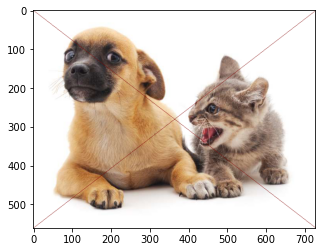

In [5]:
img_ = Image.open('.\\catdog.jpg')
draw = ImageDraw.Draw(img_)
draw.line((0, 0) + img_.size, fill=128)
draw.line((0,img_.size[1], img_.size[0], 0), fill=128)
plt.imshow(img_)
plt.show()
#img_.show()
#del draw

In [76]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
# 物体路径
object_path = 'sun.png'
# 背景文件
background_folder = 'D:\\ipynb\\background\\'
# 合成好的文件路径
target_folder = 'D:\\ipynb\\object_detection\\'
# 模型储存位置
checkpoint = 'D:\\ipynb\net\\'
# 图片合成时，物体与背景的边长比(在2个数字中随机选一个)
scale = [0.25, 0.4]
# 图片合成时，图片中的物体数量
num = [1, 2, 3]
# 图片大小
img_size = 300
# 批处理数量
batch_size = 16
# 训练分为两个阶段，分别使用不用的学习率，比如第一阶段有 30 个 epoch，学习率为 0.01
epoch_lr = [(30, 0.01), (30, 0.001), (50, 0.0001)]

In [77]:
# 数据集构建

In [79]:
# 生成物体检测标签
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import os
import re
from tqdm import tqdm

In [80]:
# 加载背景图片
def get_background():
    background_paths = osp.join('D:\\ipynb\\background\\', '*.jpg')
    return background_paths

In [81]:
# 提取物体轮廓
def extract_sun(sun):
    sun = np.array(sun)
    return np.where(np.mean(sun, axis=2) < 250)

In [82]:
list_ = []
for i in range(10):
    a = np.random.choice(num)
    list_.append(a)
list_

[3, 2, 2, 2, 2, 2, 1, 1, 2, 1]

In [83]:
np.random.random(), np.random.random() * (scale[1] - scale[0]) + scale[0], (scale[1] - scale[0]) + scale[0]

(0.5862410363678036, 0.333831050412673, 0.4)

In [84]:
a = []
for i in a:
    print(a)

In [85]:
# 合成图片
def combine_img(background_path, sun):
    sun_num = np.random.choice(num) # 从 [1, 2, 3] 里面随机选择一个数字
    background = np.array(
        Image.open(background_path).convert("RGB").resize((300, 300))
    )
    # 目标位置
    location = []
    # 目标所在像素
    coordinates = []
    for n in range(sun_num):
        located = False
        # 判断是否定位成功
        while not located:
            s = np.random.random() * (scale[1] - scale[0]) + scale[0]
            sun_size = int(img_size * s)  # img_size = 300
            sun = sun.resize((sun_size, sun_size))
            single_sun = extract_sun(sun)
            # 生成物体中心点坐标
            cx = np.random.random() * img_size
            cy = np.random.random() * img_size
            # 判断目标位置是否超界
            if ((cx + sun_size / 2 >= img_size) or 
                (cy + sun_size / 2 >= img_size) or 
                (cx - sun_size / 2 < 0) or 
                (cy - sun_size / 2 < 0)):
                continue
            # 判断是否重合
            overlap = False
            for loc in location:
                p_sun_size = loc[2]
                # 通过与之前图片中的物体的边框比来判断是否重合
                p1x = loc[0] - p_sun_size / 2
                p1y = loc[1] - p_sun_size / 2
                p2x = loc[0] + p_sun_size / 2
                p2y = loc[1] + p_sun_size / 2
                p3x = cx - sun_size / 2
                p3y = cy - sun_size / 2
                p4x = cx + sun_size / 2
                p4y = cy + sun_size / 2
                if (p1y < p4y) and (p3y < p2y) and (p1x < p4x) and (p2x > p3x):
                    overlap = True
                    break
            # 如果出现了重合，就重新生成坐标
            if overlap:
                continue
            located = True
            location.append((int(cx), int(cy), sun_size))
        # cy 对应列
        sun_coords_x = single_sun[0] + int(cy - sun_size / 2)
        sun_coords_y = sungle_sun[1] + int(cx - sun_size / 2)
        # 物体的像素坐标
        sun_coords = tuple((sun_coords_x, sun_coords_y))
        background[sun_coords] = np.array(sun)[single_sun]
        # 用于图像分割
        coordinates.append(sun_coords)
    return background, location, coordinates

In [86]:
# 生成数据集
def generate_data():
    # 加载背景图片
    background_paths = get_background()
    # 加载目标图片
    sun = Image.open(object_path).convert("RGB")
    # 如果路径不存在则创建路径
    if not osp.exists(target_folder):
        os.makedirs(target_folder)
    # 分割文件目录
    segmentation_folder = re.sub("object_detection\/$", "segmentation", target_folder)
    # 如果路径不存在则创建路径
    if not osp.exists(segmentation_folder):
        os.makedirs(segmentation_folder)
    for i, item in tqdm(enumerate(background_paths), total=len(background_paths)):
        # 合并图片并生成对应的标签
        combined_img, loc, coord = combine_img(item, sun)
        target_path = osp.join(target_folder, "{:0>3d}.jpg".format(i))
        plt.imsave(target_path, combined_img)
        # 保存边框标记文件
        with open(re.sub(".jpg", ".txt", target_path), 'w') as f:
            f.write(str(loc))
        # 保存图片掩码
        mask = np.zeros((img_size, img_size, 3))
        for c in coord:
            mask[c] = 1
        segmentation_path = osp.join(segmentation_folder, "{:0>3d}.jpg".format(i))
        plt.imsave(segmentation_path, mask)

In [98]:
a = np.array([[1, 2, 3, 5], 
             [4, 5, 6, 5], 
              [1, 2, 3, 4]])

In [99]:
np.where(np.mean(a, axis=1) < 4)

(array([0, 2], dtype=int64),)

In [101]:
np.mean(a, axis=1), np.mean(a, axis=0)

(array([2.75, 5.  , 2.5 ]),
 array([2.        , 3.        , 4.        , 4.66666667]))

In [102]:
np.array([1, 2, 3, 4]) < 3

array([ True,  True, False, False])

In [104]:
while True:
    a = 5
    for i in range(4):
        if a < 10:
            print('a = ', a)
            a += 1
            continue

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8

a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5
a =  6
a =  7
a =  8
a =  5

KeyboardInterrupt: 

In [1]:
a = [1, 2, 3, 4]
a[::-1]

[4, 3, 2, 1]

In [9]:
import numpy as np
a = []
b = []
for i in range(5):
    j = np.random.randint(2)
    b.append(j)
    if j:
        a.append(i)
a, b

([1, 2, 3], [0, 1, 1, 1, 0])

In [28]:
import torch
label_matrix = torch.zeros((3, 3))
label_matrix

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [29]:
grid_x = int(60 / 100)
grid_y = int(65 / 100)
grid_x_1 = int(160 / 100)
grid_y_1 = int(265 / 100)
grid_x, grid_y, grid_x_1, grid_y_1

(0, 0, 1, 2)

In [30]:
label_matrix[grid_y, grid_x] = 1
label_matrix[grid_y_1, grid_x_1] = 1
label_matrix

tensor([[1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]])

In [33]:
offset_matrix = torch.ones((3, 3, 3))
offset_matrix, offset_matrix[0, 0]

(tensor([[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]),
 tensor([1., 1., 1.]))

In [37]:
grid_h = grid_w = 300 / 3
grid_w, grid_h

(100.0, 100.0)

In [38]:
offset_matrix[grid_y, grid_x] = torch.tensor(
    [60 / (grid_x * grid_w + grid_w), 
     65 / (grid_y * grid_h + grid_h), 
     90 / 300])
offset_matrix

tensor([[[0.6000, 0.6500, 0.3000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]]])

In [39]:
grids = torch.Tensor([[100, 100, 100], 
                      [200, 100, 100], 
                      [300, 100, 100], 
                      [100, 200, 100], 
                      [200, 200, 100], 
                      [300, 200, 100], 
                      [100, 300, 100], 
                      [200, 300, 100], 
                      [300, 300, 100]])
grids

tensor([[100., 100., 100.],
        [200., 100., 100.],
        [300., 100., 100.],
        [100., 200., 100.],
        [200., 200., 100.],
        [300., 200., 100.],
        [100., 300., 100.],
        [200., 300., 100.],
        [300., 300., 100.]])

In [40]:
grids[0]

tensor([100., 100., 100.])

In [81]:
a = []
matrix1 = torch.tensor([[1, 2], [3, 4]])
matrix1 = matrix1.view(-1, 4)
matrix2 = torch.tensor([[2, 3], [4, 5]])
matrix2 = matrix2.view(-1, 4)
matrix1, matrix2

(tensor([[1, 2, 3, 4]]), tensor([[2, 3, 4, 5]]))

In [82]:
a.append(matrix1)
a.append(matrix2)
a

[tensor([[1, 2, 3, 4]]), tensor([[2, 3, 4, 5]])]

In [83]:
a = torch.cat(a, dim=0).long()
a

tensor([[1, 2, 3, 4],
        [2, 3, 4, 5]])

In [84]:
mask = a == 2
mask

tensor([[False,  True, False, False],
        [ True, False, False, False]])

In [85]:
mask = mask.unsqueeze(2).float()
mask, mask.size()

(tensor([[[0.],
          [1.],
          [0.],
          [0.]],
 
         [[1.],
          [0.],
          [0.],
          [0.]]]),
 torch.Size([2, 4, 1]))

In [86]:
a = torch.tensor([[1, 2, 3, 4],
                  [2, 3, 4, 5]]).long()
a, type(a)

(tensor([[1, 2, 3, 4],
         [2, 3, 4, 5]]),
 torch.Tensor)

In [88]:
0 % 3, 1 % 3, 2 % 3, 3 % 3

(0, 1, 2, 0)

In [89]:
0 // 3, 1 // 3, 2 // 3, 3 // 3

(0, 0, 0, 1)